In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 10.1

In [2]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1

#### Code 10.2

In [3]:
with pm.Model() as model_10_1:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a)    
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:02<00:00, 900.06it/s] 


In [4]:
df_10_1 = pm.df_summary(trace_10_1, alpha=0.11)
df_10_1.round(2)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.32,0.09,0.00,0.18,0.46,4000.0,NaN
bp,0.00,10.23,0.13,-16.89,15.73,4000.0,NaN


#### Code 10.3

In [5]:
logistic(df_10_1.iloc[:,-2:]).round(2)

,n_eff,Rhat
a,1.0,NaN
bp,1.0,NaN


#### Code 10.4

In [6]:
with pm.Model() as model_10_2:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    p = pm.math.invlogit(a + bp * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_2 = pm.sample(2000)

with pm.Model() as model_10_3:
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_3 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:06<00:00, 398.78it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:09<00:00, 257.59it/s]


#### Code 10.5

In [7]:
comp_df = pm.compare(traces=[trace_10_1, trace_10_2, trace_10_3],
                     models=[model_10_1, model_10_2, model_10_3],
                     method='pseudo-BMA')
comp_df.round(2)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,680.33,1.92,0,0.72,9.3,0,0
2,682.36,3.01,2.04,0.26,9.44,0.8,0
0,687.92,0.99,7.59,0.02,7.14,6.16,0


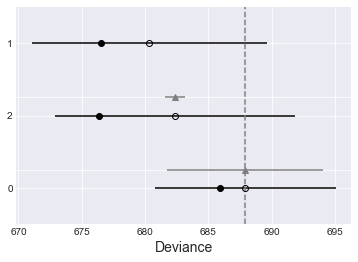

In [8]:
pm.compareplot(comp_df);

#### Code 10.6

In [9]:
pm.df_summary(trace_10_3).round(2)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.05,0.13,0.00,-0.20,0.29,4000.0,NaN
bp,0.62,0.23,0.00,0.18,1.05,4000.0,NaN
bpC,-0.10,0.26,0.01,-0.60,0.40,4000.0,NaN


#### Code 10.7

In [10]:
np.exp(0.61)

1.8404313987816374

#### Code 10.8

In [11]:
logistic(4)

0.98201379003790845

#### Code 10.9

In [12]:
logistic(4 + 0.61)

0.99014624447676869

#### Code 10.10 and 10.11

In [13]:
d_pred = pd.DataFrame({'prosoc_left' : [0, 1, 0, 1], 'condition' : [0, 0, 1, 1]})
traces = [trace_10_1, trace_10_2, trace_10_3]
models = [model_10_1, model_10_2, model_10_3]


chimp_ensemble = pm.sample_ppc_w(traces=traces, models=models, samples=1000, 
                                 weights=comp_df.weight.sort_index(ascending=True))

100%|██████████| 1000/1000 [00:00<00:00, 1198.24it/s]


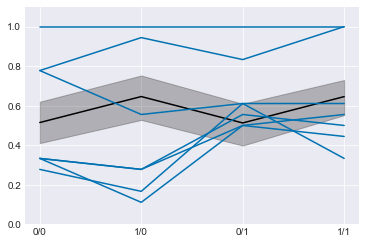

In [14]:
rt = chimp_ensemble['pulled_left']
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left==pl) & (d.chose_prosoc==cp)]))
    pred_mean[i] = tmp
    
ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d.groupby(['actor', 'prosoc_left', 'condition']).agg('mean')['pulled_left'].values.reshape(7, -1)
for i in range(7):
    plt.plot(chimps[i], 'C0')

plt.ylim(0, 1.1);

#### Code 10.12 & 10.13
This is the same as 10.6, but in the book using MCMC rather than quadratic approximation.

#### Code 10.14

In [15]:
with pm.Model() as model_10_4:
    a = pm.Normal('alpha', 0, 10, shape=len(d.actor.unique()))
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a[d.actor.values] + (bp + bpC * d.condition) * d.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d.pulled_left)

    trace_10_4 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 2491/2500 [00:14<00:00, 202.11it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 11 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [00:14<00:00, 170.79it/s]
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 8 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


#### Code 10.15

In [16]:
# remember we use a zero-index
d['actor'].unique()

array([0, 1, 2, 3, 4, 5, 6])

#### Code 10.16

In [17]:
pm.df_summary(trace_10_4, alpha=0.11).round(2)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha__0,-0.75,0.27,0.01,-1.19,-0.32,28000.0,0.94
alpha__1,10.87,5.34,0.13,3.56,18.39,NaN,NaN
alpha__2,-1.06,0.29,0.01,-1.52,-0.60,NaN,NaN
alpha__3,-1.06,0.28,0.01,-1.50,-0.62,NaN,NaN
alpha__4,-0.75,0.27,0.00,-1.18,-0.31,NaN,NaN
alpha__5,0.21,0.27,0.00,-0.22,0.64,NaN,NaN
alpha__6,1.80,0.40,0.01,1.12,2.39,NaN,NaN
bp,0.86,0.27,0.01,0.46,1.31,4000.0,NaN
bpC,-0.14,0.30,0.01,-0.62,0.34,4000.0,NaN


#### Code 10.17

In [18]:
post = pm.trace_to_dataframe(trace_10_4)
post.head()

,alpha__0,alpha__1,alpha__2,alpha__3,alpha__4,alpha__5,alpha__6,bp,bpC
0,-0.552485,10.754418,-0.769759,-1.358485,-0.899096,0.260771,1.603986,0.881459,-0.282698
1,-1.002920,7.398638,-1.129570,-0.763224,-1.283298,0.439750,2.555469,1.029446,-0.507572
2,-0.902694,12.676341,-1.577896,-0.946091,-0.996340,0.421256,1.795130,1.027332,-0.396731
3,-0.687616,5.706977,-0.728997,-1.192963,-0.686621,-0.108505,1.811839,0.543585,-0.241836
4,-1.108308,13.365459,-0.890946,-1.362019,-0.634538,0.336944,1.934851,0.786971,0.045495


#### Code 10.18

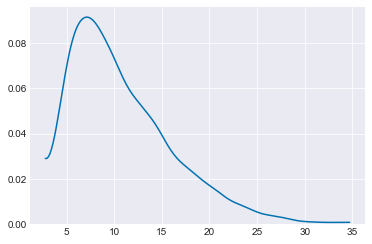

In [19]:
pm.kdeplot(post['alpha__1']);

#### Code 10.19

In [20]:
rt = pm.sample_ppc(trace_10_4, 1000, model_10_4)['pulled_left']

100%|██████████| 1000/1000 [00:00<00:00, 1058.20it/s]


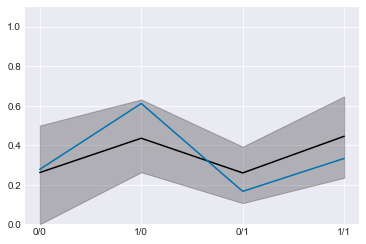

In [21]:
chimp = 2
pred_mean = np.zeros((1000, 4))
cond = d.condition.unique()
prosoc_l = d.prosoc_left.unique()
for i in range(len(rt)):
    tmp = []
    for cp in cond:
        for pl in prosoc_l:
            tmp.append(np.mean(rt[i][(d.prosoc_left == pl) & (d.chose_prosoc == cp) & (d.actor == chimp)]))
    pred_mean[i] = tmp

ticks = range(4)
mp = pred_mean.mean(0)
hpd = pm.hpd(pred_mean, alpha=0.11)
plt.fill_between(ticks, hpd[:,1], hpd[:,0], alpha=0.25, color='k')
plt.plot(mp, color='k')
plt.xticks(ticks, ("0/0","1/0","0/1","1/1"))
chimps = d[d.actor == chimp].groupby(['condition', 'prosoc_left', ]).agg('mean')['pulled_left'].values
plt.plot(chimps, 'C0')

plt.ylim(0, 1.1);

#### Code 10.20

In [22]:
d_aggregated = d.groupby(['actor', 'condition', 'prosoc_left',  ])['pulled_left'].sum().reset_index()
d_aggregated.head(7)

,actor,condition,prosoc_left,pulled_left
0,0,0,0,6
1,0,0,1,9
2,0,1,0,5
3,0,1,1,10
4,1,0,0,18
5,1,0,1,18
6,1,1,0,18


#### Code 10.21

In [23]:
with pm.Model() as model_10_5:
    a = pm.Normal('alpha', 0, 10)
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    p = pm.math.invlogit(a + (bp + bpC * d_aggregated.condition) * d_aggregated.prosoc_left)
    pulled_left = pm.Binomial('pulled_left', 18, p, observed=d_aggregated.pulled_left)

    trace_10_5 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:04<00:00, 573.42it/s]


In [24]:
pm.df_summary(trace_10_5)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.043679,0.122929,0.002555,-0.184429,0.296670,4000.0,NaN
bp,0.627084,0.223544,0.005199,0.181322,1.047770,4000.0,NaN
bpC,-0.116281,0.266599,0.005985,-0.632032,0.406614,4000.0,NaN


In [25]:
# hacky check of similarity to 10_3, within a hundreth
np.isclose(pm.df_summary(trace_10_5), pm.df_summary(trace_10_3), atol=0.01)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


array([[ True,  True,  True, False,  True,  True, False],
       [False,  True,  True,  True,  True,  True, False],
       [False,  True,  True, False,  True,  True, False]], dtype=bool)

#### Code 10.22

In [26]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


#### Code 10.23

In [27]:
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)

with pm.Model() as model_10_6:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a + bm * d_ad.male)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_6 = pm.sample(2000, tune=1000)
    
with pm.Model() as model_10_7:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_10_7 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3000/3000 [00:04<00:00, 717.00it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3000/3000 [00:02<00:00, 1291.13it/s]


#### Code 10.24

In [28]:
# Something goofy here... 
# not even close to WAIC values, larger standard error

comp_df = pm.compare([trace_10_6, trace_10_7], [model_10_6, model_10_7], method='pseudo-BMA')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
0,996.01,116.74,0,1,315.03,0,1
1,1049.79,81.14,53.78,0,315.24,159.21,1


#### Code 10.25

In [29]:
pm.df_summary(trace_10_6).round(2)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-0.83,0.05,0.0,-0.92,-0.73,4000.0,NaN
bm,0.61,0.06,0.0,0.48,0.73,4000.0,NaN


#### Code 10.26

In [30]:
post = pm.trace_to_dataframe(trace_10_6)
p_admit_male = logistic(post['a'] + post['bm'])
p_admit_female = logistic(post['a'])
diff_admit = p_admit_male - p_admit_female
diff_admit.describe(percentiles=[.025, .5, .975])[['2.5%', '50%', '97.5%']]

2.5%     0.112870
50%      0.141469
97.5%    0.169544
dtype: float64

#### Code 10.27

(0, 1)

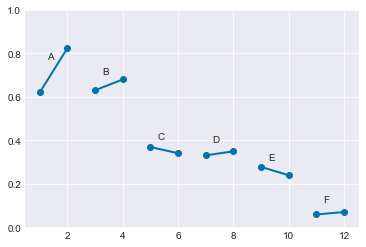

In [31]:
for i in range(6):
    x = 1 + 2 * i
    y1 = d_ad.admit[x] / d_ad.applications[x]
    y2 = d_ad.admit[x+1] / d_ad.applications[x+1]
    plt.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    plt.text(x + 0.25, (y1+y2)/2 + 0.05, d_ad.dept[x])
plt.ylim(0, 1)

#### Code 10.28

In [32]:
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

In [33]:
with pm.Model() as model_10_8:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    p = pm.math.invlogit(a[d_ad['dept_id'].values])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_8 = pm.sample(2000)

with pm.Model() as model_10_9:
    a = pm.Normal('a', 0, 10, shape=len(d_ad['dept'].unique()))
    bm = pm.Normal('bm', 0, 10)
    p = pm.math.invlogit(a[d_ad['dept_id'].values] + bm * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad['applications'], observed=d_ad['admit'])
    
    trace_10_9 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:04<00:00, 595.39it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:06<00:00, 410.01it/s]


#### Code 10.29

In [34]:
# WAIC values still off
# Plus warning flag

comp_df = pm.compare(traces=[trace_10_6, trace_10_7, trace_10_8, trace_10_9],
                     models=[model_10_6, model_10_7, model_10_8, model_10_9], method='pseudo-BMA')
comp_df

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
2,105.24,6.59,0,0.83,17.2,0,1
3,108.44,9.4,3.19,0.17,15.54,3.67,1
0,996.01,116.74,890.76,0,315.03,312.09,1
1,1049.79,81.14,944.55,0,315.24,312.94,1


#### Code 10.30

In [35]:
pm.df_summary(trace_10_9).round(2)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a__0,0.68,0.10,0.0,0.48,0.86,8452.0,0.91
a__1,0.64,0.12,0.0,0.42,0.87,NaN,NaN
a__2,-0.58,0.07,0.0,-0.72,-0.43,NaN,NaN
a__3,-0.61,0.09,0.0,-0.79,-0.45,NaN,NaN
a__4,-1.06,0.10,0.0,-1.25,-0.86,NaN,NaN
a__5,-2.64,0.16,0.0,-2.94,-2.32,NaN,NaN
bm,-0.10,0.08,0.0,-0.26,0.05,4000.0,NaN


#### Code 10.31
Replicated model above but with MCMC in book.

#### Code 10.38

In [36]:
y = stats.binom.rvs(n=1000, p=1/1000, size=100000)
np.mean(y), np.var(y)

(0.99870999999999999, 0.99182833589999997)

#### Code 10.39

In [37]:
dk = pd.read_csv('Data/Kline', sep=';')
dk

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


#### Code 10.40

In [38]:
dk.log_pop = np.log(dk.population)
dk.contact_high = (dk.contact == "high").astype(int)

#### Code 10.41

In [39]:
with pm.Model() as m_10_10:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=3)
    lam = pm.math.exp(a + b[0] * dk.log_pop + b[1] * dk.contact_high + b[2] * dk.contact_high * dk.log_pop)
    total_tools = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_10_10 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 997/1000 [00:11<00:00, 81.59it/s] /home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.907287223008, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:11<00:00, 89.92it/s]
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.886735194035, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


#### Code 10.42

In [40]:
pm.df_summary(trace_10_10)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.933048,0.354127,0.015669,0.188720,1.593682,1000.0,NaN
b__0,0.264550,0.034194,0.001501,0.205229,0.339797,3000.0,0.936199
b__1,-0.117672,0.844835,0.044520,-1.826852,1.450845,NaN,NaN
b__2,0.045974,0.093072,0.004823,-0.122452,0.232756,NaN,NaN


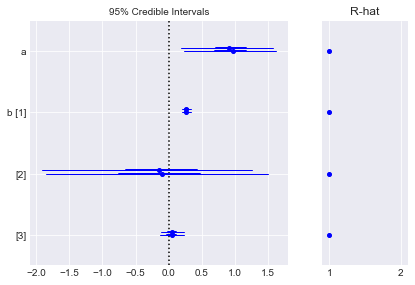

In [41]:
pm.forestplot(trace_10_10)

#### Code 10.43

In [42]:
lambda_high = np.exp(trace_10_10['a'] + trace_10_10['b'][:,1] + (trace_10_10['b'][:,0] + trace_10_10['b'][:,2]) * 8)
lambda_low = np.exp(trace_10_10['a'] + trace_10_10['b'][:,0] * 8 )

#### Code 10.44

In [43]:
diff = lambda_high - lambda_low
np.sum(diff > 0) / len(diff)

0.95499999999999996

#### Code 10.45

In [44]:
with pm.Model() as m_10_11:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1, shape=2)
    lam = pm.math.exp(a + b[0] * dk.log_pop + b[1] * dk.contact_high)
    total_tools = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_10_11 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:05<00:00, 167.94it/s]


#### Code 10.46

In [45]:
with pm.Model() as m_10_12:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * dk.log_pop)
    total_tools = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_10_12 = pm.sample()
    
with pm.Model() as m_10_13:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 1)
    lam = pm.math.exp(a + b * dk.contact_high)
    total_tools = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_10_13 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:03<00:00, 255.56it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:01<00:00, 589.90it/s]




#### Code 10.47

In [46]:
with pm.Model() as m_10_14:
    a = pm.Normal('a', 0, 100)
    lam = pm.math.exp(a)
    total_tools = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_10_14 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 89%|████████▉ | 889/1000 [00:00<00:00, 1306.23it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.878860278075, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:00<00:00, 1260.32it/s]


In [47]:
traces = [trace_10_10, trace_10_11, trace_10_12, trace_10_13, trace_10_14]
models = [m_10_10, m_10_11, m_10_12, m_10_13, m_10_14]

islands_compare = pm.compare(traces, models, method='pseudo-BMA')

In [48]:
islands_compare

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
1,78.5,3.95,0,0.68,10.77,0,1
0,80.24,4.93,1.74,0.28,11.2,1.19,1
2,84.17,3.55,5.67,0.04,8.87,7.55,1
4,140.43,7.37,61.92,0,31.42,32.49,1
3,151.83,17.81,73.32,0,45.2,44.88,1


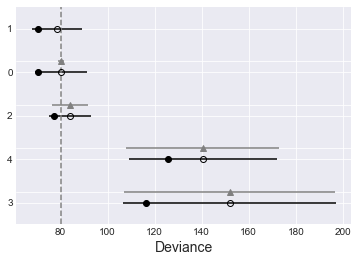

In [49]:
pm.compareplot(islands_compare);

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

#### Code 10.xx

In [50]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.2
IPython 6.1.0
PyMC3 3.2
NumPy 1.13.1
Pandas 0.20.3
SciPy 0.19.1
Matplotlib 2.0.2

